In [43]:
import numpy as np
import pandas as pd
import shutil, time, os, requests, random, copy
import PIL
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

import preprocessing.VideoFrameDataset as VFD
import model.Encoder as E
import model.Loss as L

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
model = E.ResNet50Encoder()  
model = model.to(device)
state_dict = torch.load('/home/aarya/Desktop/TCLR_Frame_Based_Anomaly/kaggle_sessions/saved_models/1_28_25_0.0001_7_0.1_ResNet-50.pth')
model.load_state_dict(state_dict)

/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/aarya/miniconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



<All keys matched successfully>

In [45]:
dataset = VFD.VideoFrameDataset('/home/aarya/Desktop/TCLR_Frame_Based_Anomaly/data/camera_1_videos', 5)
dataloader = DataLoader(dataset, 1, shuffle=False)

In [46]:
datapoints = np.empty((0, 64))
with torch.no_grad():
    for batch in dataloader:
        video = batch[0]
        for frame in video:
            frame = frame.unsqueeze(dim = 0)
            frame = frame.to(device)
            output = model(frame)
            datapoints = np.vstack([datapoints, output.detach().cpu().numpy()])

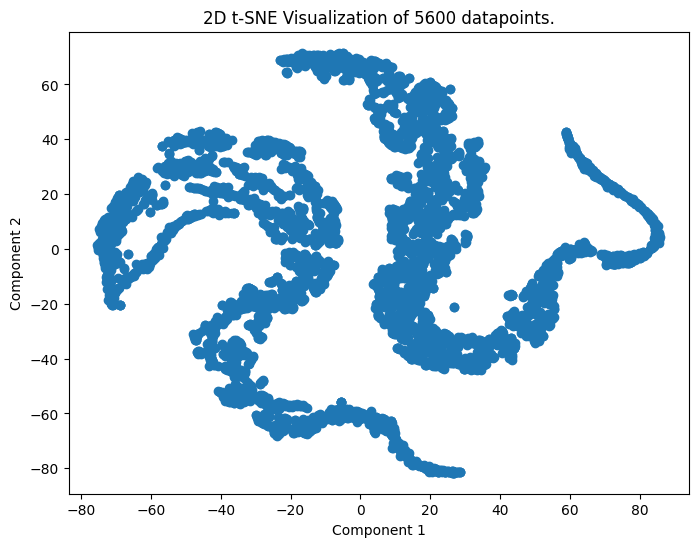

In [47]:
tsne_2D = TSNE(n_components=2, perplexity=30)
tsne_results_2D = tsne_2D.fit_transform(datapoints)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [97]:
import model.Loss as L
data = datapoints
data = transforms.ToTensor()(data)
data = data.squeeze(dim = 0).to(device)
print(data.shape)
similarity_matrix = L.pairwise_cosine_similarity(data, data)
similarity_matrix = similarity_matrix.detach().cpu().numpy()
similarity_matrix = 1 + 4.4e-15 - similarity_matrix 
print(similarity_matrix.min())

torch.Size([5600, 64])
3.9968028886505635e-15


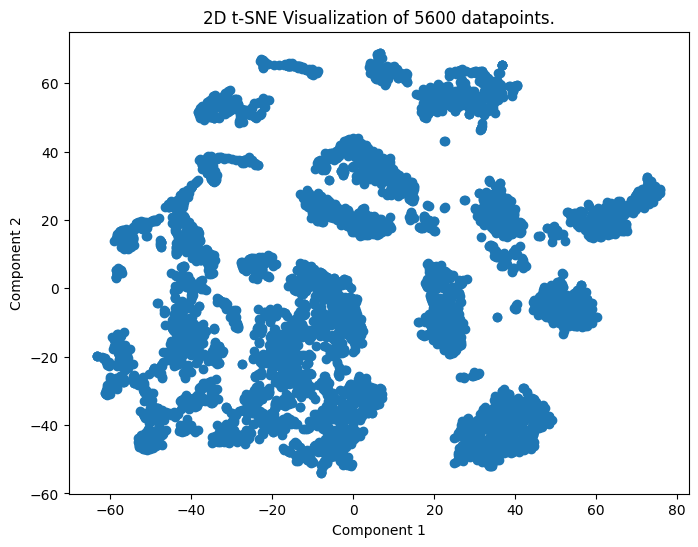

In [98]:
tsne_2D = TSNE(metric = "precomputed", perplexity=30, n_components=2, init='random')
tsne_results_2D = tsne_2D.fit_transform(similarity_matrix)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [50]:
import plotly.graph_objects as go
tsne_3D = TSNE(n_components=3, perplexity=30)
tsne_results_3D = tsne_3D.fit_transform(datapoints)
trace = go.Scatter3d(
    x=tsne_results_3D[:, 0],
    y=tsne_results_3D[:, 1],
    z=tsne_results_3D[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # Adjust marker size as needed
        opacity=0.8,  # Adjust marker opacity as needed
    )
)

# Create the layout for the plot
layout = go.Layout(
    title="3D t-SNE Visualization",
    width=1200,  # Set width in pixels
    height=800,
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

# Combine the trace and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [51]:
import plotly.graph_objects as go
tsne_3D = TSNE(metric = "precomputed", n_components=3, perplexity=30, init="random")
tsne_results_3D = tsne_3D.fit_transform(similarity_matrix)
trace = go.Scatter3d(
    x=tsne_results_3D[:, 0],
    y=tsne_results_3D[:, 1],
    z=tsne_results_3D[:, 2],
    mode='markers',
    marker=dict(
        size=5,  # Adjust marker size as needed
        opacity=0.8,  # Adjust marker opacity as needed
    )
)

# Create the layout for the plot
layout = go.Layout(
    title="3D t-SNE Visualization",
    width=1200,  # Set width in pixels
    height=800,
    scene=dict(
        xaxis_title='Component 1',
        yaxis_title='Component 2',
        zaxis_title='Component 3'
    )
)

# Combine the trace and layout into a figure
fig = go.Figure(data=[trace], layout=layout)

# Display the interactive plot
fig.show()

In [99]:
transform = transforms.ToTensor()
anomalous = cv2.imread('anomalous_frame.jpg')
anomalous = Image.fromarray(anomalous)
anomalous = transform(anomalous).to(device)
anomalous = anomalous.unsqueeze(dim=0)
anomalous.shape

torch.Size([1, 3, 256, 256])

In [100]:
with torch.no_grad():
    anomalous = model(anomalous)

In [101]:
stacked_data = np.vstack([datapoints, anomalous.detach().cpu().numpy()])

In [102]:
stacked_data.shape

(5601, 64)

In [103]:
data = stacked_data
data = transforms.ToTensor()(data)
data = data.squeeze(dim = 0).to(device)
print(data.shape)
similarity_matrix = L.pairwise_cosine_similarity(data, data)
similarity_matrix = similarity_matrix.detach().cpu().numpy()
similarity_matrix = 1 + 4.4e-15 - similarity_matrix 
print(similarity_matrix.min())

torch.Size([5601, 64])
3.9968028886505635e-15


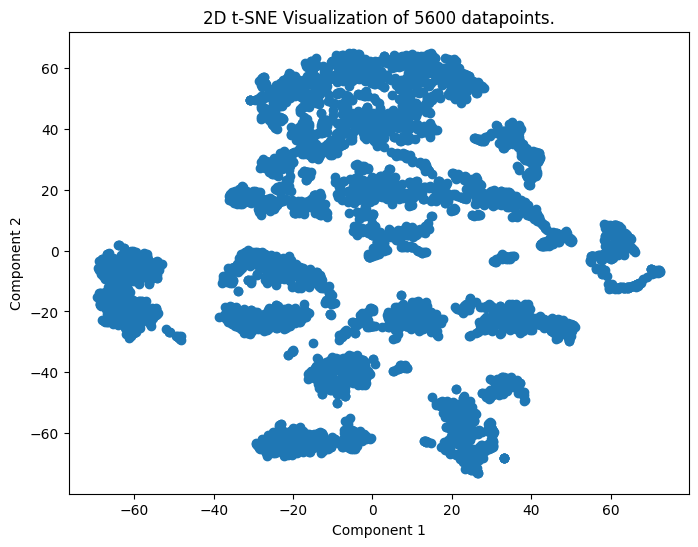

In [57]:
tsne_2D = TSNE(metric = "precomputed", perplexity=30, n_components=2, init='random')
tsne_results_2D = tsne_2D.fit_transform(similarity_matrix)
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results_2D[:, 0], tsne_results_2D[:, 1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("2D t-SNE Visualization of 5600 datapoints.")
plt.show()

In [104]:
from model.Loss import pairwise_cosine_similarity
print(stacked_data.shape)
tr = transforms.ToTensor()
data = tr(stacked_data).squeeze(dim = 0)
print(data.shape)
similarity_matrix = pairwise_cosine_similarity(data, data).numpy()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_data = tr(scaled_data)
scaled_data = scaled_data.squeeze(dim = 0)
similarity_matrix = pairwise_cosine_similarity(scaled_data, scaled_data).numpy() + 1
print(similarity_matrix.min())
print(similarity_matrix.max())
print(similarity_matrix.mean())

(5601, 64)
torch.Size([5601, 64])
0.0001351054646639982
2.000000000000001
1.0020791277241408


In [61]:
from sklearn.cluster import DBSCAN
i = 0.1
while(i!=1):
    eps = i # Maximum allowed distance for points to be considered neighbors
    min_samples = 350 # Minimum number of neighbors to form a cluster
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

    # Fit the model on the similarity matrix
    dbscan.fit(similarity_matrix)

    # Get labels for each data point
    labels = dbscan.labels_

    # Identify anomalies (points labeled -1, noise)
    anomalies = data[labels == -1]

    # Print the number of anomalies found
    print(f"Number of anomalies found: {len(anomalies)} at {i}")
    if(len(anomalies) == 0):
        break
    i += 0.01

Number of anomalies found: 23 at 0.1
Number of anomalies found: 21 at 0.11
Number of anomalies found: 21 at 0.12
Number of anomalies found: 21 at 0.13
Number of anomalies found: 18 at 0.14
Number of anomalies found: 17 at 0.15000000000000002
Number of anomalies found: 14 at 0.16000000000000003
Number of anomalies found: 14 at 0.17000000000000004
Number of anomalies found: 14 at 0.18000000000000005
Number of anomalies found: 14 at 0.19000000000000006
Number of anomalies found: 13 at 0.20000000000000007
Number of anomalies found: 13 at 0.21000000000000008
Number of anomalies found: 13 at 0.22000000000000008
Number of anomalies found: 13 at 0.2300000000000001
Number of anomalies found: 13 at 0.2400000000000001
Number of anomalies found: 13 at 0.2500000000000001
Number of anomalies found: 13 at 0.2600000000000001
Number of anomalies found: 12 at 0.27000000000000013
Number of anomalies found: 12 at 0.28000000000000014
Number of anomalies found: 10 at 0.29000000000000015
Number of anomalies 